# Palmer Penguins: Multiclass Classification Notebook
---

## 1. Machine learning in scikit-learn

This Jupyter notebook demonstrates a full machine learning workflow for the Palmer Penguins dataset, of data taken at Palmer Station, Antarctica. It covers:
 - Data loading with pandas
 - Exploratory data analysis
 - Data cleaning and preprocessing (encoding, scaling, train-test split)
 - Model training
 - Comparison of out-of-sample performance and training time
 - SHAP interpretability for one of our models


### NOTE: run this notebook in a Python environment with the following packages installed:
`pandas`, `numpy`, `matplotlib`, `seaborn`, `scikit-learn`, `shap (>=0.40)`

In [2]:
# Our machine learning will use scikit-learn
#import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier
)
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# We will load our data into pandas dataframes
import pandas as pd

# We will use these to make plots
import matplotlib.pyplot as plt
import seaborn as sns

# We will time our models to compare them
import time

## 2. Load the Data

In this section, we load the Palmer Penguins dataset, which contains measurements of penguin species observed in the Palmer Archipelago, Antarctica.  
The dataset includes biological and physical attributes—such as bill length, flipper length, and body mass—for three species of penguins: **Adélie**, **Chinstrap**, and **Gentoo**.

The dataset can be loaded directly from [Allison Horst’s GitHub repository](https://github.com/allisonhorst/palmerpenguins), which provides the canonical version of the Palmer Penguins data in CSV format.

We have copied the data to [our GitHub repository](https://github.com/Hosseinhamedi/SWB_Predictive_Analytics_Machine_Leanring).

In [3]:
df = pd.read_csv("../data/penguins_noisy.csv")

Let's quickly look at the data we just loaded:

In [4]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,41.6,16.8,199.0,4150.0,male,2007
1,Adelie,Torgersen,38.8,18.3,197.0,4450.0,female,2007
2,Adelie,Torgersen,43.5,12.2,186.0,2770.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,35.5,16.4,166.0,2220.0,female,2007


We notice a few things about the data.

- The data has both string and numerical columns.

- There is some missing data, denoted by NaN.

- There is a column we won't end up using: year.

We can also look at the dataframe's info() to get broad information about the data:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
 7   year               344 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 21.6+ KB


## 3. Exploratory Data Analysis (EDA)

Before we build any models, we explore and visualize the data to understand its structure, distribution, and relationships between variables.

In this section, we:
- Visualize numerical feature distributions (e.g., bill length, flipper length, body mass).
- Compare how these features differ across penguin species.
- Explore relationships and correlations between numeric predictors.

We will build an intuition for what distinguishes each penguin species and identify which variables may be most useful for classification.

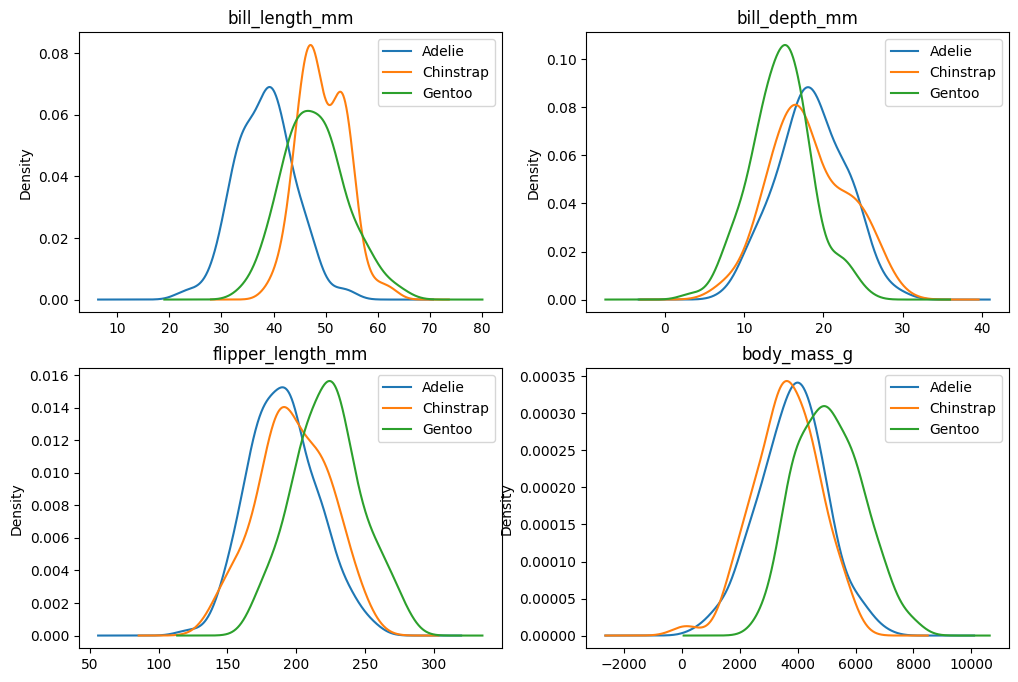

In [6]:
col_names = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

plt.figure(figsize=(12, 8))
for i, col in enumerate(col_names, 1):
    plt.subplot(2, 2, i)
    df.groupby('species')[col].plot(kind='density', legend=True)
    plt.title(col)
plt.show()

Here's a bar graph of the species on each island:

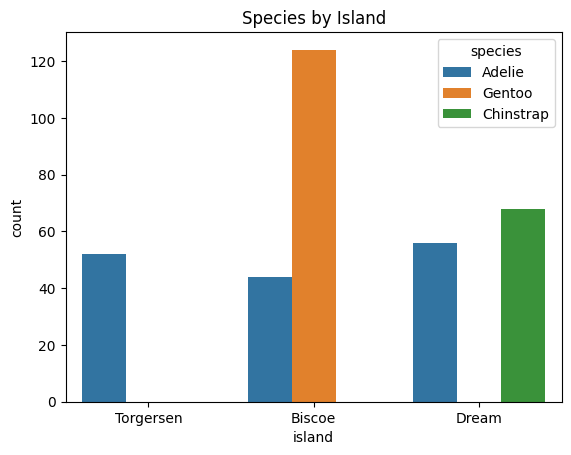

In [7]:
sns.countplot(x='island', hue='species', data=df)
plt.title('Species by Island')
plt.show()

Species by sex:

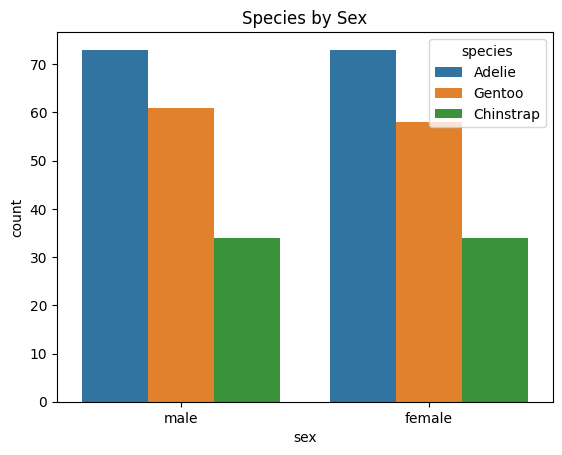

In [8]:
sns.countplot(x='sex', hue='species', data=df)
plt.title('Species by Sex')
plt.show()

Our exploratory analysis gives us a solid understanding of the data's structure and potential issues.  

Next, we'll clean and preprocess the dataset to ensure it's ready for modeling.

## 4. Data Cleaning and Preprocessing

Raw data typically requires cleaning and transformation before it can be used effectively for modeling.  
In this section, we prepare the data for training by performing the following steps:

1. **Handling Missing Values:**

2. **Encoding Categorical Variables:**  
   Convert string-based features such as `island` and `sex` into numerical form using one-hot encoding.

3. **Feature Scaling:**  
   Standardize numeric predictors (mean = 0, standard deviation = 1) to ensure models like logistic regression and SVM are not biased by variable scale differences.

4. **Train-Test Split:**  
   Split the dataset into a training and testing set using stratified sampling to maintain class balance across penguin species.

After preprocessing, the cleaned dataset will be ready for fitting a variety of classification models.

We drop the NaN data:

In [9]:
df = df.dropna()

It's good to be organized and reset_index on the dataframe now:

In [11]:
df = df.reset_index(drop=True)

Now we split the data into (x, y) pairs, where we map the x data to the y targets.

We will use the species as the y data, and the remaining columns as the x data.

In [12]:
TARGET = 'species'
y = df[TARGET]

X = df[['island', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']]

Here is the shape of our data, having 6 columns:

In [13]:
print(X.shape, y.shape)

(333, 6) (333,)


In [14]:
y

0         Adelie
1         Adelie
2         Adelie
3         Adelie
4         Adelie
         ...    
328    Chinstrap
329    Chinstrap
330    Chinstrap
331    Chinstrap
332    Chinstrap
Name: species, Length: 333, dtype: object

In [15]:
X.head()

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Torgersen,41.6,16.8,199.0,4150.0,male
1,Torgersen,38.8,18.3,197.0,4450.0,female
2,Torgersen,43.5,12.2,186.0,2770.0,female
3,Torgersen,35.5,16.4,166.0,2220.0,female
4,Torgersen,38.1,19.7,205.0,2190.0,male


We need to replace the words with numbers so we can train our models.

In [16]:
X = pd.get_dummies(X, dtype=float)

In [17]:
X.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen,sex_female,sex_male
0,41.6,16.8,199.0,4150.0,0.0,0.0,1.0,0.0,1.0
1,38.8,18.3,197.0,4450.0,0.0,0.0,1.0,1.0,0.0
2,43.5,12.2,186.0,2770.0,0.0,0.0,1.0,1.0,0.0
3,35.5,16.4,166.0,2220.0,0.0,0.0,1.0,1.0,0.0
4,38.1,19.7,205.0,2190.0,0.0,0.0,1.0,0.0,1.0


### Normalize the data before model input

Mean = 0, standard deviation = 1

In [18]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [19]:
X_scaled

array([[-0.32642532, -0.04949189, -0.15938272, ...,  2.46680084,
        -0.99103121,  0.99103121],
       [-0.69987191,  0.27450807, -0.22930953, ...,  2.46680084,
         1.00904996, -1.00904996],
       [-0.07301514, -1.04309176, -0.61390696, ...,  2.46680084,
         1.00904996, -1.00904996],
       ...,
       [ 0.90061347,  0.879308  , -1.27821162, ..., -0.40538335,
        -0.99103121,  0.99103121],
       [ 1.06066201,  0.20970808,  0.0154343 , ..., -0.40538335,
        -0.99103121,  0.99103121],
       [ 0.48715475,  0.0369081 , -1.66280905, ..., -0.40538335,
         1.00904996, -1.00904996]], shape=(333, 9))

Now that our dataset is preprocessed and standardized, we can begin training classification models to predict penguin species.

### Train-test split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

The previous function also conveniently puts the data in a random order:

## 5. Training a Model

Now that the data is clean and standardized, we train several classification algorithms to predict the penguin species.

We will compare a range of models representing different algorithmic families:
- **Multilayer perception (MLP)** — a standard neural network model
- **Logistic Regression** — a linear baseline model
- **Random Forest** — an ensemble of decision trees with bootstrap aggregation
- **Support Vector Machine (SVM)** — a margin-based classifier
- **Gradient Boosting** — a powerful boosting-based ensemble method

Each model is trained and evaluated using cross-validation to estimate its out-of-sample accuracy.  

We also record training time to understand the trade-offs between model complexity, performance, and computational efficiency.

### Define a model

We'll start off by defining a typical neural network model, a multilayer peceptron model (MLP), and looking at it in some detail.

Here's a diagram of an MLP. It maps the Input data, X, to the Output data, y, with a complex set of Hidden layers in the middle:

![title](https://ars.els-cdn.com/content/image/1-s2.0-S0925231223004502-gr1.jpg)

The MLP classifier model is built into Scikit-learn:

In [22]:
models = {}

models['MLP'] = MLPClassifier(
    hidden_layer_sizes=(8, 8),
    max_iter=1000,
    random_state=42)

### Train the model

Scikit-learn, and most machine learning programs, have a built-in fit function that will conveniently train the model for us.

In [23]:
models['MLP'].fit(X_train, y_train)

,hidden_layer_sizes,"(8, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,1000
,shuffle,True
,random_state,42


Plot the training loss over time:

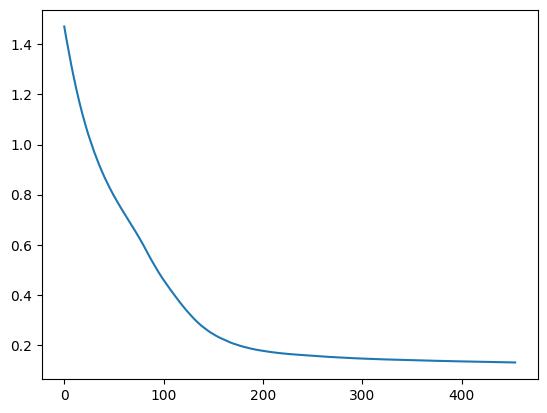

In [25]:
plt.plot(models['MLP'].loss_curve_)
plt.show()

We can see that the model stopped training after the loss value levelled off near a stable minimum.

### Use the trained model to do predictions on the test data

In [26]:
y_pred = models['MLP'].predict(X_test)

### Evaluate the model predictions

In [27]:
accuracy_score(y_test, y_pred)

0.9253731343283582

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Adelie       0.96      0.86      0.91        29
   Chinstrap       0.93      0.93      0.93        14
      Gentoo       0.89      1.00      0.94        24

    accuracy                           0.93        67
   macro avg       0.93      0.93      0.93        67
weighted avg       0.93      0.93      0.92        67



In [29]:
confusion_matrix(y_test, y_pred)

array([[25,  1,  3],
       [ 1, 13,  0],
       [ 0,  0, 24]])

There's an sklearn function, ConfusionMatrixDisplay, that will plot this nicely.

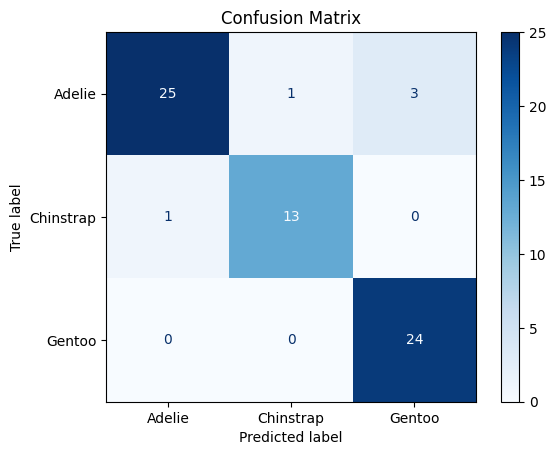

In [30]:
cm = confusion_matrix(y_test, y_pred, labels=models['MLP'].classes_)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=models['MLP'].classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## Comparing different models

Logistic Regression

In [31]:
models['LogisticRegression'] = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=5000, n_jobs=-1)

Random Forest

In [32]:
models['RandomForest'] = RandomForestClassifier(random_state=42, n_jobs=-1)

Support Vector Machine (SVM)

In [33]:
models['SVM'] = SVC(kernel='rbf', probability=True)

Gradient Boosting

In [34]:
models['GradientBoosting'] = GradientBoostingClassifier()

In [35]:
print(f"Models: {models}\n")

Models: {'MLP': MLPClassifier(hidden_layer_sizes=(8, 8), max_iter=1000, random_state=42), 'LogisticRegression': LogisticRegression(max_iter=5000, multi_class='multinomial', n_jobs=-1,
                   solver='saga'), 'RandomForest': RandomForestClassifier(n_jobs=-1, random_state=42), 'SVM': SVC(probability=True), 'GradientBoosting': GradientBoostingClassifier()}




=== MLP ===
Accuracy: 0.9253731343283582
Training time: 0.23134565353393555 seconds.


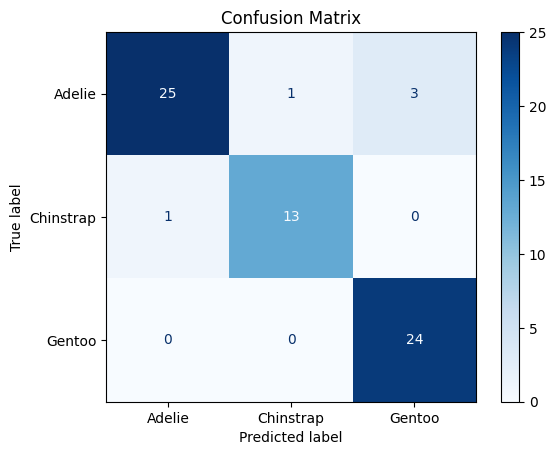

Classification Report:

              precision    recall  f1-score   support

      Adelie       0.96      0.86      0.91        29
   Chinstrap       0.93      0.93      0.93        14
      Gentoo       0.89      1.00      0.94        24

    accuracy                           0.93        67
   macro avg       0.93      0.93      0.93        67
weighted avg       0.93      0.93      0.92        67


=== LogisticRegression ===
Accuracy: 0.9402985074626866
Training time: 0.014287948608398438 seconds.


/home/adam/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


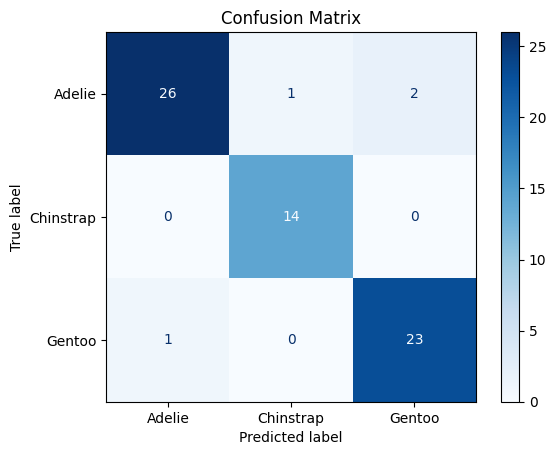

Classification Report:

              precision    recall  f1-score   support

      Adelie       0.96      0.90      0.93        29
   Chinstrap       0.93      1.00      0.97        14
      Gentoo       0.92      0.96      0.94        24

    accuracy                           0.94        67
   macro avg       0.94      0.95      0.94        67
weighted avg       0.94      0.94      0.94        67


=== RandomForest ===
Accuracy: 0.9253731343283582
Training time: 0.09688448905944824 seconds.


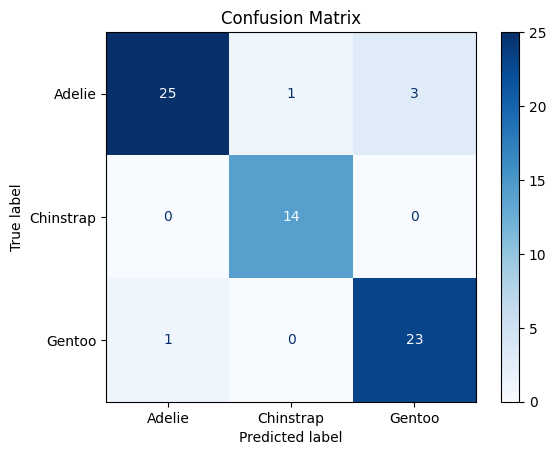

Classification Report:

              precision    recall  f1-score   support

      Adelie       0.96      0.86      0.91        29
   Chinstrap       0.93      1.00      0.97        14
      Gentoo       0.88      0.96      0.92        24

    accuracy                           0.93        67
   macro avg       0.93      0.94      0.93        67
weighted avg       0.93      0.93      0.92        67


=== SVM ===
Accuracy: 0.9253731343283582
Training time: 0.0057332515716552734 seconds.


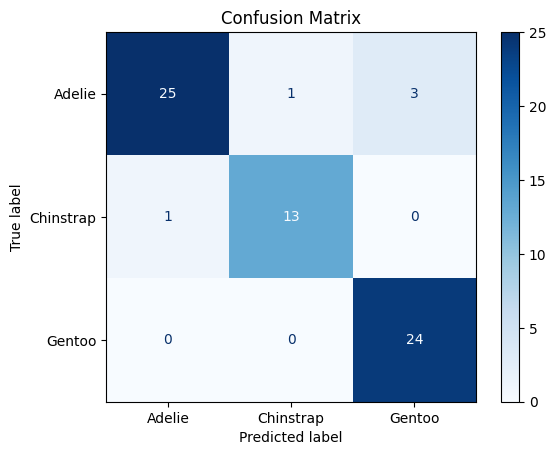

Classification Report:

              precision    recall  f1-score   support

      Adelie       0.96      0.86      0.91        29
   Chinstrap       0.93      0.93      0.93        14
      Gentoo       0.89      1.00      0.94        24

    accuracy                           0.93        67
   macro avg       0.93      0.93      0.93        67
weighted avg       0.93      0.93      0.92        67


=== GradientBoosting ===
Accuracy: 0.8955223880597015
Training time: 0.24329519271850586 seconds.


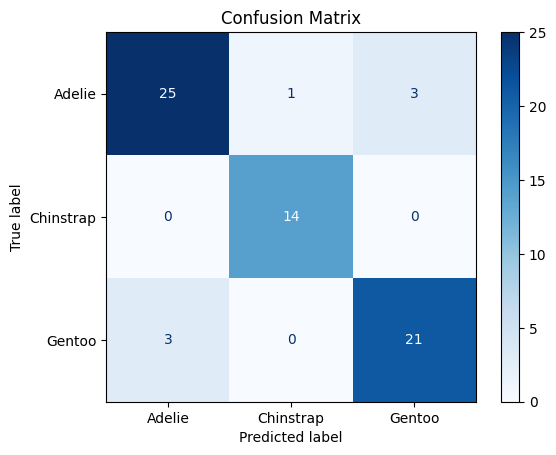

Classification Report:

              precision    recall  f1-score   support

      Adelie       0.89      0.86      0.88        29
   Chinstrap       0.93      1.00      0.97        14
      Gentoo       0.88      0.88      0.88        24

    accuracy                           0.90        67
   macro avg       0.90      0.91      0.91        67
weighted avg       0.89      0.90      0.89        67


Models Comparison:
                model  accuracy  precision    recall        f1  train_time_s
1  LogisticRegression  0.940299   0.938765  0.951628  0.944288      0.014288
0                 MLP  0.925373   0.926333  0.930213  0.926280      0.231346
2        RandomForest  0.925373   0.926496  0.940134  0.931536      0.096884
3                 SVM  0.925373   0.926333  0.930213  0.926280      0.005733
4    GradientBoosting  0.895522   0.900397  0.912356  0.905903      0.243295


In [36]:
results = []
for name, estimator in models.items():
    print(f"\n=== {name} ===")
    model = models[name]
    start = time.time()
    model.fit(X_train, y_train)
    elapsed = time.time() - start
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print('Accuracy:', acc)
    print(f'Training time: {elapsed} seconds.')

    # 1) Metrics results
    results.append({
        'model': name,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'train_time_s': elapsed,
    })

    # 2) Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # 3) Classification report
    report = classification_report(y_test, y_pred, target_names=model.classes_)
    print("Classification Report:\n")
    print(report)

results_df = pd.DataFrame(results).sort_values('accuracy', ascending=False)
print("\nModels Comparison:")
print(results_df)

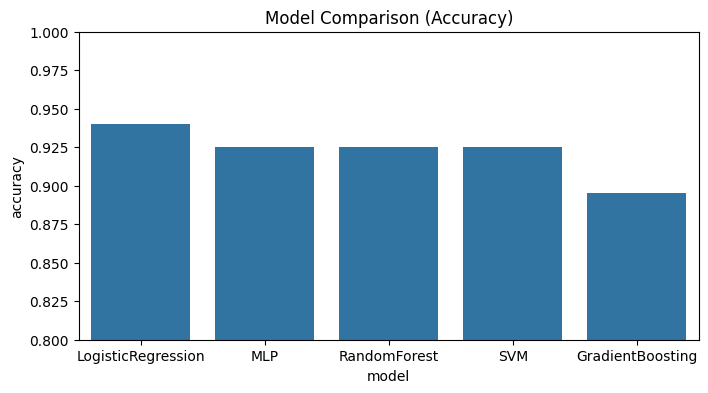

In [37]:
plt.figure(figsize=(8, 4))
sns.barplot(x='model', y='accuracy', data=results_df)
plt.ylim(0.8, 1)
plt.title('Model Comparison (Accuracy)')
plt.show()

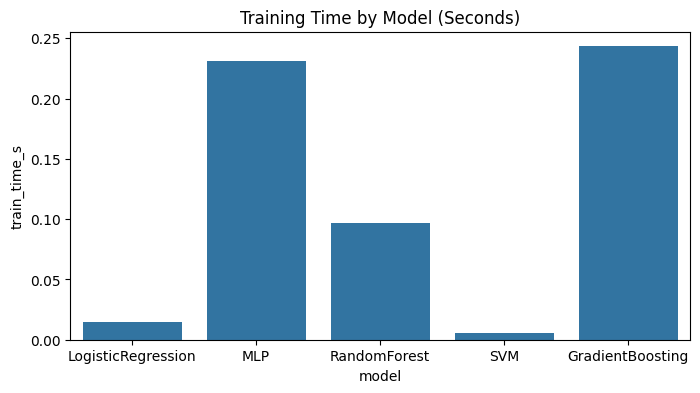

In [38]:
plt.figure(figsize=(8, 4))
sns.barplot(x='model', y='train_time_s', data=results_df)
plt.title('Training Time by Model (Seconds)')
plt.show()

## 7. Model Interpretability with SHAP

While predictive accuracy is important, understanding *why* a model makes its predictions is equally valuable — especially for scientific and policy-related data like ecological research.

We use **SHAP (SHapley Additive exPlanations)** (https://arxiv.org/pdf/1705.07874) to interpret our best-performing model.  

SHAP values quantify each feature's contribution to the model's predictions for individual observations and overall.

In this section, we:
- Compute SHAP values for a representative subset of the data.
- Visualize **global feature importance** to see which variables most strongly influence species classification.
- Optionally inspect **individual prediction explanations** (e.g., using waterfall or force plots).

These insights allow us to connect model predictions back to biological intuition — for instance, how bill length or flipper size help differentiate between penguin species.

In [40]:
import shap

In [41]:
# 1) Identify the best model
best_model_name = results_df.iloc[0]['model']
print("Best model:", best_model_name)

Best model: LogisticRegression


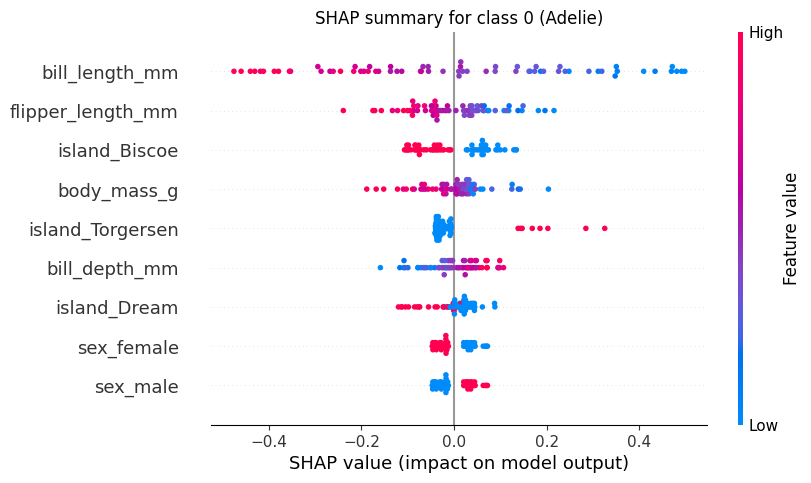

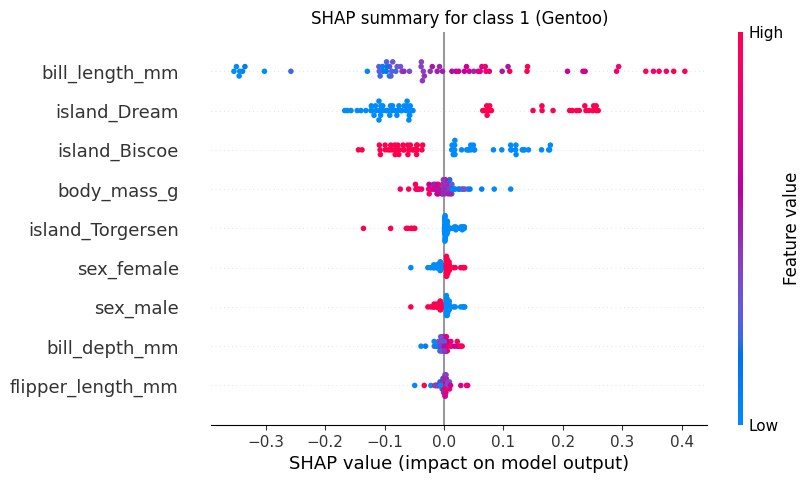

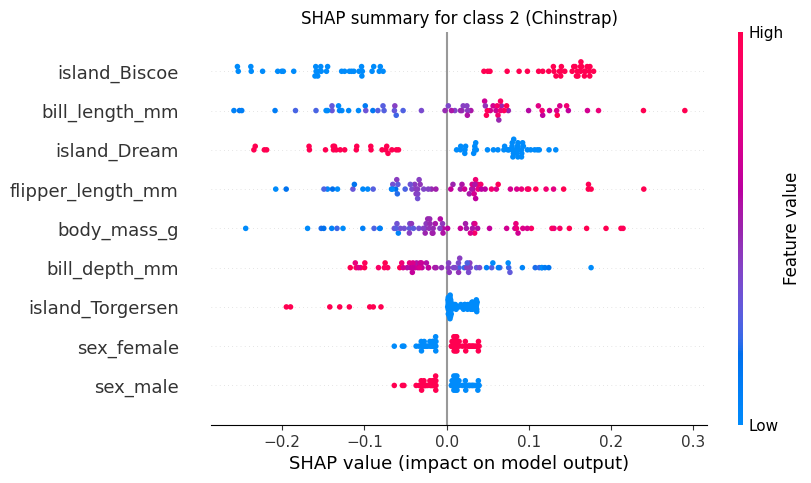

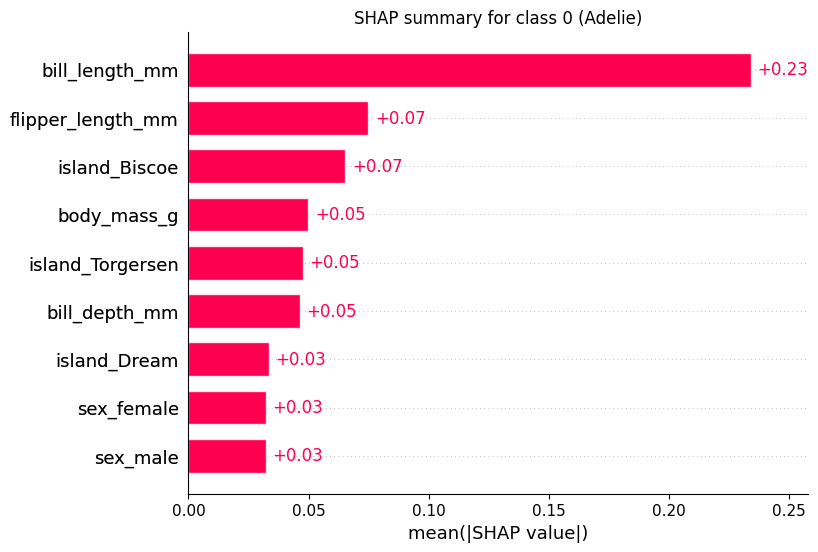

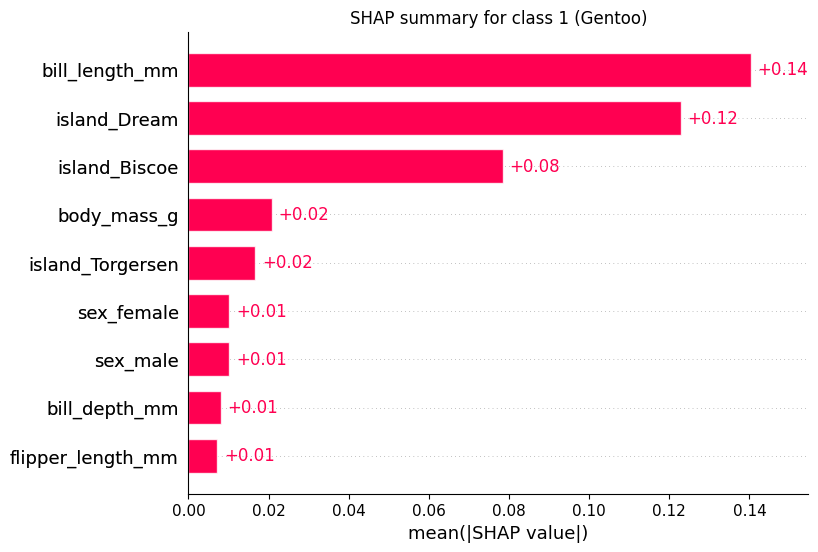

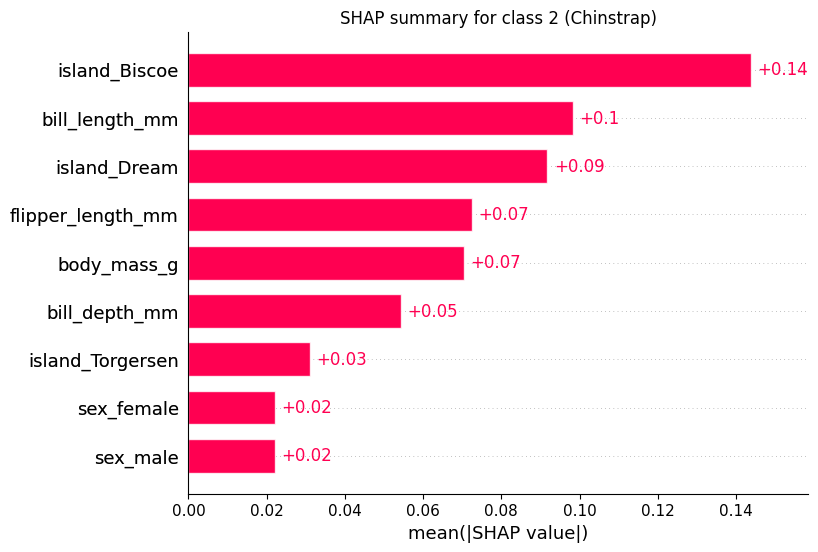

In [42]:
# 2) Safely retrieve the best model
model_entry = models.get(best_model_name)
model = model_entry[0] if isinstance(model_entry, (list, tuple)) else model_entry


# Function to produce per-class SHAP explanations and plots
def explain_multiclass_with_shap(
        model,
        X_background,
        feature_names=None,
        class_names=None,
        plot_type="beeswarm",  # "beeswarm" or "bar"
        nsamples=200,          # passed to explainer(X, nsamples=...)
    ):
    """
    For each class in the model, create an explainer for that class's predicted probability
    and show a summary plot (beeswarm or bar). Does NOT slice shap values manually.
    """
    # Check the model has predict_proba
    if not hasattr(model, "predict_proba"):
        raise ValueError("Model must implement predict_proba(X).")

    # Get number of classes from a predict_proba call on a small subset
    sample_probs = model.predict_proba(X_background[:5])
    n_classes = sample_probs.shape[1]

    if class_names is None:
        class_names = [f"class_{i}" for i in range(n_classes)]

    # Loop through classes and explain
    for class_idx in range(n_classes):
        def proba_fn(X):
            """
            Return a function f(X) -> probabilities of class `class_index`.
            Works for sklearn-like models with predict_proba.
            """
            # sklearn predict_proba expects 2D array
            probs = model.predict_proba(X)
            
            # probs shape -> (n_samples, n_classes)
            return probs[:, class_idx]

        
        # Create a SHAP explainer for this single-output probability function.
        # We pass an informative masker (Independent) or let SHAP choose.
        explainer = shap.Explainer(
            proba_fn,
            shap.maskers.Independent(X_background),
            feature_names=feature_names,
            output_names=[class_names[class_idx]]
        )

        # Compute explanations for the dataset we want to summarize (could be X_test)
        # nsamples controls approximation sampling for Kernel/Permutation explainers; for TreeExplainer it's ignored.
        shap_exp = explainer(X_background, max_evals=nsamples)  # for newer SHAP versions 'max_evals' or 'nsamples' may be accepted

        title = f"SHAP summary for class {class_idx} ({class_names[class_idx]})"
        plt.figure(figsize=(8, 5))
        plt.title(title)

        if plot_type == "beeswarm":
            # beeswarm expects a single-output Explanation object — exactly what we created
            shap.plots.beeswarm(shap_exp)
        elif plot_type == "bar":
            # bar (mean absolute) summary
            shap.plots.bar(shap_exp)
        else:
            raise ValueError("plot_type must be 'beeswarm' or 'bar'")

        plt.show()


# Run the explainer & show per-class plots
feature_names = X.columns.tolist()
class_names = y.unique().tolist()

explain_multiclass_with_shap(
    model=model,
    X_background=X_test,
    feature_names=feature_names,
    class_names=class_names,
    plot_type="beeswarm",  # or "bar"
    nsamples=512
)

explain_multiclass_with_shap(
    model=model,
    X_background=X_test,
    feature_names=feature_names,
    class_names=class_names,
    plot_type="bar",  # or "bar"
    nsamples=512
)

## 8. Conclusion

We've completed a full end-to-end machine learning workflow:
- Loaded and explored the Palmer Penguins dataset  
- Cleaned and preprocessed the data  
- Trained and tuned multiple classifiers  
- Interpreted the final model using SHAP  

The analysis highlights how modern ML tools like gradient boosting and SHAP can provide both high accuracy and transparent interpretability — helping us not only predict penguin species but also understand the traits that distinguish them.

### Things we didn't cover:

- Hyperparameter tuning: We chose our model hyperparameters somewhat arbitrarily. There are algorithms to tune the hyperparameters for us, or, we could have trained the models multiple times on different sets of hyperparameters.
- Validation set: We split up the data into train and test sets, but it is standard to also have a validation set. The validation set is not trained on, and is monitored during training to prevent overtraining.
- Using a GPU: Large, modern machine learning models are almost always trained on GPUs. scikit-learn does not have GPU functionality, but PyTorch and TensorFlow do.

## Appendix

The noisy penguin data was made from the penguin data with the following code:

```
import numpy as np
np.random.seed(42)

df['bill_length_mm'] += np.random.normal(0, 5, size=len(df))
df['bill_length_mm'] = df['bill_length_mm'].round(1)

df['bill_depth_mm'] += np.random.normal(0, 4, size=len(df))
df['bill_depth_mm'] = df['bill_depth_mm'].round(1)

df['flipper_length_mm'] += np.random.normal(0, 25, size=len(df))
df['flipper_length_mm'] = df['flipper_length_mm'].round(0)

df['body_mass_g'] += np.random.normal(0, 1000, size=len(df))
df['body_mass_g'] = df['body_mass_g'].round(-1)
```

In [ ]:
adamrouhiainen@proton.me